<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Michael Kazachok (@miklgr500)

# <center>Другая сторона tensorflow:KMeans

## <center>Введение

<p style="text-indent:20px;">  Многие знают <strong>tensorflow</strong>, как одну из лучших библиотек для обучения нейронных сетей, но в последнее время tensorflow довольно сильно вырос. Появились новые <a href='https://www.tensorflow.org/programmers_guide/estimators'>Estimators</a>, которые более удобны, чем старая парадигма, являющаяся фундаментом для новой.</p>
<p style="text-indent:20px;">  На сайте <a href = 'https://www.tensorflow.org/'>tensorflow</a> будет хорошая инструкция по установке под определенную операционную ситему и возможностях использование <a href = 'https://ru.wikipedia.org/wiki/GPGPU'>GPGPU</a>.Я не буду грузить данную работу особенностями "кухни" tensorflow (поэтому советую почитать хотябы основы в <a href='https://www.tensorflow.org/tutorials/'>официальном тьюториале</a> и посмотреть <a href='https://github.com/aymericdamien/TensorFlow-Examples'>TensorFlow Tutorial and Examples for Beginners with Latest APIs</a>; там же есть примеры, которые помогут в дальнейшем в изучении нейронных сетей), а я пройдусь по уже прошитым в этой либе алгоритмам крастеризации(а их фактически пока только два).</p>
<p style="text-indent:20px;">  При этом будет использоваться набор данных с Kaggel для соревнования <a href = 'https://www.kaggle.com/chicago/chicago-taxi-rides-2016'>Chicago Taxi Rides 2016</a>, который использовался в одной из домашек (<span style='color:green'>рекомендую использовать не более двух месяцев</span>).</p>
<p style="text-indent:20px;">  Применение простейшего алгоритма кластеризации в tensorflow будет сопроваждаться рассмотрением вопросов изящной визуализации (которую я увидел этим летом на соревнований Kaggle <a href = 'https://www.kaggle.com/c/nyc-taxi-trip-duration'>New York City Taxi Trip</a>), представленой <a href = 'https://www.kaggle.com/drgilermo'>DrGuillermo</a> и <a href = 'https://www.kaggle.com/maheshdadhich'>BuryBuryZymon</a> в их работах <a href = 'https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation'>Dynamics of New York city - Animation</a> и <a href = 'https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial'>Strength of visualization-python visuals tutorial</a> на соревновании.</p>

<p style="text-indent:20px;"><i>P.S. На написание данного тьюториала автора сподвигло довольно плохая освещенность возможностей tensorflow для создания уже довольно хорошо всем известных простых алгоритмов машинного обучения, которые для определенных задачах могут быть более эфективны, чем сложные алгоритмы машинного обучения.</i></p>

## <center>Подключение используемых в работе библиотек и загрузка данных

In [1]:
FIG_SIZE = (12,12)
PATH_DATA_JSON = '../../data/column_remapping.json'
PATH_DATA_CSV = '../../data/chicago_taxi_trips_2016_*.csv'
GIF_PATH = '../../img/animation.gif'
KMEANS_GIF_PATH='../../img/kmeans_animation.gif'
NUM_CLUSTERS = 5
BATCH_SIZE = 5
NUM_STEPS = 50
LON_CONST = -87.623177
LAT_CONST = 41.881832
LON_ANI_CENTER = [-87.73, -87.60]
LAT_ANI_CENTER = [41.85, 42.00]

In [2]:
import json
import pandas as pd
from glob import glob
from joblib import Parallel, delayed

import folium
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from matplotlib.patches import Ellipse
from IPython.display import HTML
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import tensorflow as tf
from geopy.geocoders import Nominatim

import io
import base64
from dateutil import parser

%load_ext watermark

Версии основных библиотек и параметры системы.

In [3]:
%watermark -v -m -p numpy,pandas,matplotlib,tensorflow -g

CPython 3.5.2
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
matplotlib 2.1.0
tensorflow 1.4.0-rc0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.10.0-37-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : f403a4676b99fce59d623f5adaf83f7af6b384ba


Открываем данные за два первых месяца. Будте внимательны со ссылками на данные.

In [4]:
#ядро которое будем использовать 
#для загруски и преобработки данных за один месяц
def preproc_kernel(path):
    with open(PATH_DATA_JSON) as json_file:
        column_remapping = json.load(json_file)
    df = pd.read_csv(path)
    # в дальнейшем понадобяться только геоданные
    # и время начала поездки
    df = df.loc[:, [
        'trip_start_timestamp',
        'pickup_latitude',
        'pickup_longitude',
        'dropoff_latitude',
        'dropoff_longitude']].dropna()
    geo_labels = ['pickup_latitude',
                  'pickup_longitude',
                  'dropoff_latitude',
                  'dropoff_longitude']
    for g in geo_labels:
        df[g] = df[g].apply(lambda x: float(column_remapping[g].get(str(int(x)))))
    return df


dataset_files = sorted(glob(PATH_DATA_CSV))
# выполняем загрузку данных параллельно
# на двух ядрах, каждому по одному файлу
dfs = Parallel(n_jobs=2)(delayed(preproc_kernel)(path) for path in dataset_files)
# склеиваем данные
df = pd.concat(dfs, ignore_index=True)
df.head()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2016-1-13 06:15:00,41.901207,-87.676356,41.901207,-87.676356
1,2016-1-23 17:30:00,41.944227,-87.655998,41.944227,-87.655998
2,2016-1-8 18:15:00,41.899602,-87.633308,41.965812,-87.655879
3,2016-1-26 04:15:00,41.953582,-87.723452,41.953582,-87.723452
4,2016-1-22 11:30:00,41.892508,-87.626215,41.884987,-87.620993


## <center> Визуализация данных

Произведем предварительную визуализацию всех гео данных и выявим их границы.

In [5]:
# соединяем гео данные для точек посадки и точек высадки
longitude = list(df.pickup_longitude)+list(df.dropoff_longitude)
print('max_long:'+str(max(longitude)))
print('min_long:'+str(min(longitude)))
latitude = list(df.pickup_latitude)+list(df.dropoff_latitude)
print('max_lat:'+str(max(latitude)))
print('min_lat:'+str(min(latitude)))

loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

max_long:-87.534902901
min_long:-87.913624596
max_lat:42.021223593
min_lat:41.660136051


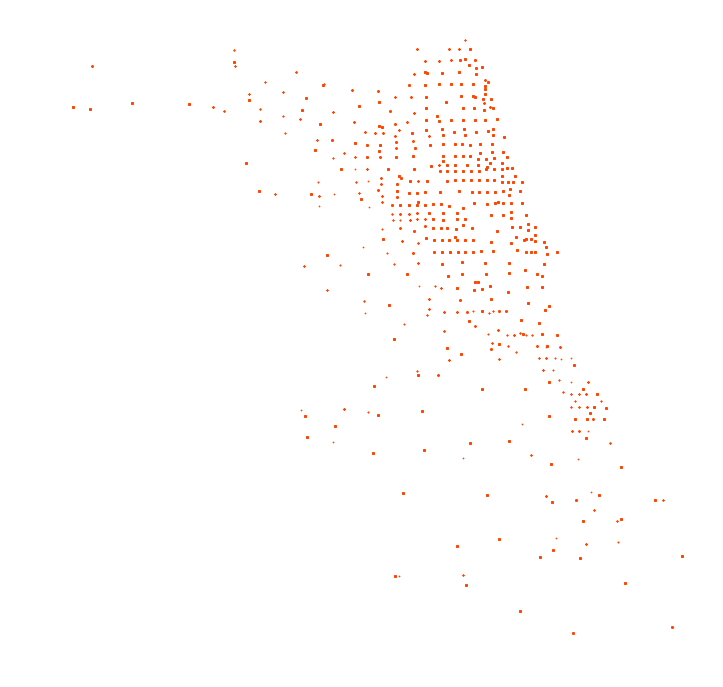

In [6]:
#производим визуализацию объединенных гео данных
fig, ax = plt.subplots(1,1, figsize = FIG_SIZE)
plt.plot(longitude, 
         latitude, 
         '.', 
         color = 'orangered',
         markersize = 1.5, 
         axes = ax, 
         figure = fig
    )
ax.set_axis_off()
plt.show();

<p style="text-indent:20px;">Мало что можно сказать про количество кластеров из графика выше. Но если вывести рапределение по широте и долготе, то картина немного прояснится.</p>

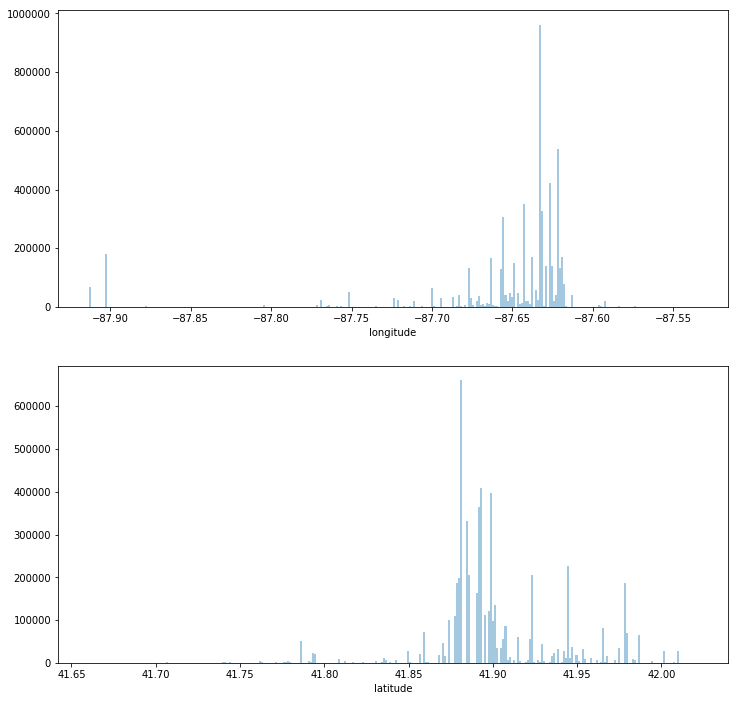

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=FIG_SIZE)

sns.distplot(loc_df['longitude'], bins=300, kde=False, ax=ax1)
sns.distplot(loc_df['latitude'], bins=300, kde=False, ax=ax2)
plt.show();

<p style="text-indent:20px;">Из графиков выше видно, что наибольший трафик приходится практически на центр города. При этом стоит отметить, наличее довольно сильно выделяющегося трафика на долготе -87.90, а по долготе правея центра выделятся три центра с ярко выраженным трафиков.  Таким образом кроме одного основного яровыделяющего по трафику центра есть еще как миниму четыре центра, которые можно выделить в отдельный кластер. В итоге можно выделить пять кластеров, которые имеют ярковыраженый трафик.</p> 


## <center>Kmean в tensorflow

<p style="text-indent:20px;">Пожалуй это один из самых востребованных алгоритмов кластеризации на на данный момент. Не думаю, что тут стоит излагать теорию (учитывая, что она затрагивалась в <a href='https://habrahabr.ru/company/ods/blog/325654/'>лекции курса</a>), если кто-то хочет почитать что-то еще по данному алгоритму и по кластеризации в целом, то я пожалуй могу посоветовать <a href='http://www.machinelearning.ru/wiki/images/2/28/Voron-ML-Clustering-slides.pdf'>лекции К.В.Воронцова</a>.</p>

In [8]:
# формируем массив с данными в нужном формате
# т.е. формируем пары [lon, lat]
# Для правильной работы алгоритма
# неообходимо омязательно избавиться от
# постоянной компаненты
data = [[(lon-LON_CONST), (lat-LAT_CONST)] for lon, lat in zip(longitude, latitude)]
data = np.array(data)

<p style="text-indent:20px;">В качестве основы выберем уже прошитый в tensorflow алгоритм <a href='https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/factorization/KMeans'>KMeans</a>(<a href='https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/contrib/factorization/python/ops/clustering_ops.py'>люблю открытый код</a>). Те кто разобрал открытый код, мог заметить, что из большого набора функций вызвать можем только <i>training_graph(self)</i>. Обратите внимание возвращается ли в вашей версии tensorflow данная функция переменную <i>cluster_centers_var</i>(в 1.3 она не возвращается).</p>

In [9]:
 def KMeans_clustering(num_clusters=NUM_CLUSTERS, flag_print=True):
    # создаем placeholder X
    # подставляя его вместо каких-то знаений
    # мы говорим вычислительному графу
    # что эти значения будут предоставлены потом: 
    # в процессе обучения и/или инициализации
    X = tf.placeholder(tf.float32, shape=[None, 2])

    # производим построение вычислительного графа для KMeans
    kmeans = tf.contrib.factorization.KMeans(
        inputs=X,
        num_clusters=num_clusters,
        initial_clusters="kmeans_plus_plus",
        mini_batch_steps_per_iteration=BATCH_SIZE,
        random_seed=29,
        use_mini_batch=True
    )
    
    (all_scores,cluster_idx, scores,cluster_centers_initialized,\
     cluster_centers_var,init_op,train_op) = kmeans.training_graph()
    
    # т.к. изначально возвращается tuple
    # то берем только первый его член
    cluster_idx = cluster_idx[0]
    # производим расчет средней дистанции 
    # точек до своего кластера
    avg_distance = tf.reduce_mean(scores)

    # создание сессии и инициальзация
    init_vars = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init_vars)
    sess.run(init_op, feed_dict={X: data})

    # пошагово обучаем модель
    # получая на каждом шаге
    # d:среднюю дистанцию от точки 
    # до центра своего кластера
    #----------------------------
    # задаем критерии остановки

    for i in range(1,NUM_STEPS+1):
        _, d, idx, cl_c = sess.run([train_op, 
                                    avg_distance,
                                    cluster_idx,
                                    cluster_centers_var],
                                    feed_dict={X: data}
                            )
        
        if (i%10==0)&(flag_print):
            print('Step %i, Average Distance %.8f'%(i, d))
    sess.close()
    return d,idx,cl_c

<p style="text-indent:20px;">Визуализируем работу алгоритма, произведя инициализацию всех кластеров в координате [LON_CONST, LAT_CONST], являющеся центром города.</p>


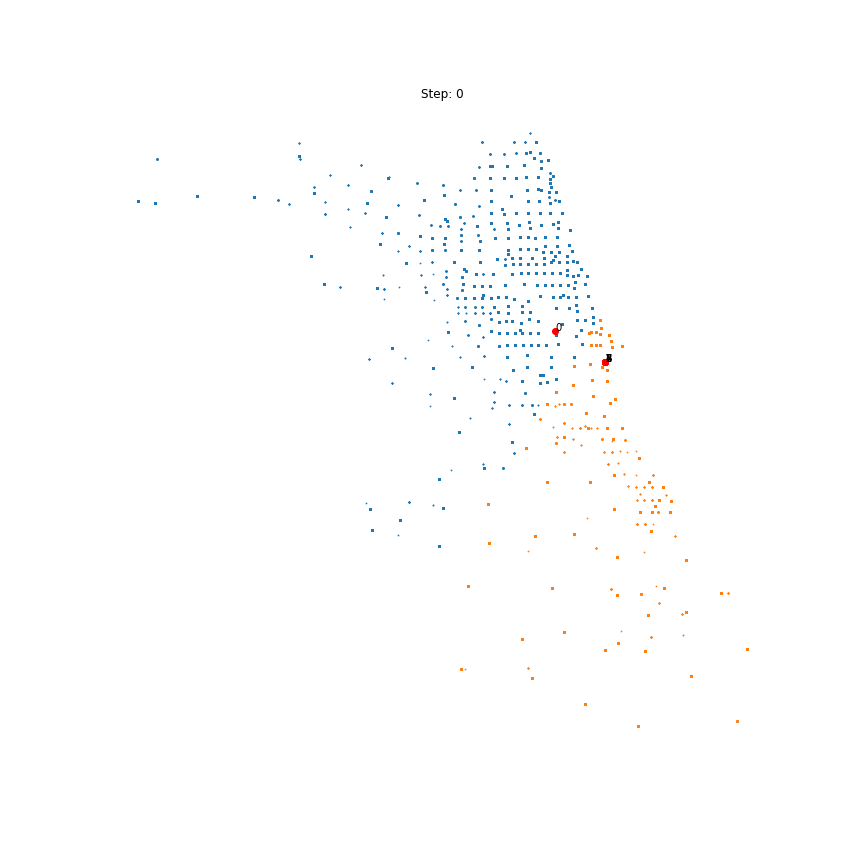

In [10]:
# сделаем анимацию обучения
num_clusters = 8

# массив для инициализации кластеров
# в точке [LON_CONST, LAT_CONST], но 
# т.к. у нас все данные смещенны на 
# значение данной координаты,
# то инициализацию необходимо провести 
# в точке [0, 0]
init_cl = np.array([[0, 0] for i in range(num_clusters)],
                   dtype=np.float32
            )
X = tf.placeholder(tf.float32, shape=[None, 2])
# производим построение вычислительного графа для KMeans
kmeans = tf.contrib.factorization.KMeans(
    inputs=X,
    num_clusters=num_clusters,
    initial_clusters=init_cl,
    mini_batch_steps_per_iteration=2,
    random_seed=29,
    use_mini_batch=False
)
    
(all_scores,cluster_idx, scores,cluster_centers_initialized,\
     cluster_centers_var,init_op,train_op) = kmeans.training_graph()
# т.к. изначально возвращается tuple
# то берем только первый его член
cluster_idx = cluster_idx[0]
avg_distance = tf.reduce_mean(scores)

# создание сессии и инициальзация
init_vars = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_vars)
sess.run(init_op, feed_dict={X: data})
fig, ax = plt.subplots(1,1, figsize = FIG_SIZE)
# задаем функцию, которую передадим в animation.FuncAnimation
# эта функция будет производить просчет полученого графика
# на каждом шагу, но так как mini_batch_steps_per_iteration=2
# то изменение будут каждые 2 шага, всего шагов будет 10
# их мы непосредственно будем задавать в FuncAnimation
# в виде массива и FuncAnimation пошагово будет передовать
# заданные значения в animate_kmeans
def animate_kmeans(step):
    _, d, idx, cl_c = sess.run([train_op, 
                                avg_distance,
                                cluster_idx,
                                cluster_centers_var],
                                feed_dict={X: data}
                        )
    # для упрощения работы с полученными данными после обучения
    # создается DataFrame, который в конце кода будет удален
    # данное решение может быть не совсем оптимально
    # оно просто упрощает жизнь вашему слуге =)
    loc_df['labels'] = idx
    cl_df = pd.DataFrame()
    cl_df['longitude'] = cl_c[:,0]+LON_CONST
    cl_df['latitude'] = cl_c[:,1]+LAT_CONST
    cl_df['labels'] = cl_df.index
    # обязательно чистим предыдущий график
    ax.clear()
    ax.set_title('Step: '+str(step))
    for l in cl_df['labels']:
        ax.plot(loc_df.loc[loc_df['labels'] == l, 'longitude'], 
                loc_df.loc[loc_df['labels'] == l, 'latitude'], 
                '.',
                markersize = 1.5
            )
        ax.plot(cl_df.loc[cl_df['labels'] == l, 'longitude'], 
                cl_df.loc[cl_df['labels'] == l, 'latitude'], 
                'ro'
            )
        ax.annotate(s=str(l),
                    xy=(cl_df.loc[cl_df['labels'] == l, 'longitude'], 
                    cl_df.loc[cl_df['labels'] == l, 'latitude'])
                )
    
    ax.set_axis_off()
    del cl_df
    
ani = animation.FuncAnimation(fig,
                              animate_kmeans,
                              list(range(0, 20)),
                              interval=500
                    )
# производим закрытие отрисованных графиков
plt.close()
# дириктори сохранения гифки
gif_path = KMEANS_GIF_PATH
# сохранение гифки
ani.save(gif_path,
         writer='imagemagick',
         fps=1
        )
# открываем сохраненную гифку и производим ее дешифрование
# для дальнейшего URL и подстановки их в HTML
video = io.open(gif_path,
                'r+b'
            ).read()
encoded = base64.b64encode(video)
# производим отрисовку анимации в notebook
HTML(data='''<img src="data:image/gif;base64,{0}"type="gif"/>'''.format(
    encoded.decode('ascii')))               

<p style="text-indent:20px;">Видно что обновление происходит каждые 2 шага за счет установки mini_batch_steps_per_iteration=2. Вы можете поиграться с кодом выше! Выставте другую инициализацию("kmeans_plus_plus","random") или поиграйтесь с параметрами для mini_batch, а можно и вовсе изменить количество кластеров!</p>

<p style="text-indent:20px;">Найдем оптимальное число кластеров по методу, который был предложен на лекции,а пока идут вычисления можно заварить чашечку кофе и изучить новый алгоритм =)<p>

In [11]:
n_cluster = range(1,15,1)
avg_distance = []
for i in n_cluster:
    d,idx,cl_c = KMeans_clustering(num_clusters=i, flag_print=False)
    avg_distance.append(d)

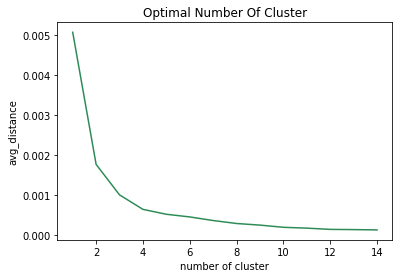

In [12]:
plt.plot([i for i in n_cluster], avg_distance, color = 'seagreen')
plt.xlabel('number of cluster')
plt.ylabel('avg_distance')
plt.title('Optimal Number Of Cluster')
plt.show();

<p style="text-indent:20px;">Из графика видно, что ничего не видно=). Опять гадаем=) Я бы взять 4 кластера, и это довольно неплохо согласуется с предыдущей оценкой, поэтому возмем 5 кластеров(в данном случае лучше взять большее число, т.о. получится более детальная картина трафика).</p>

In [13]:
NUM_CLUSTERS = 5
 
d,idx,cl_c = KMeans_clustering(num_clusters=NUM_CLUSTERS, flag_print=True)

Step 10, Average Distance 0.00053107
Step 20, Average Distance 0.00052832
Step 30, Average Distance 0.00052820
Step 40, Average Distance 0.00052820
Step 50, Average Distance 0.00052820


<p style="text-indent:20px;">Добавим метки кластеров в loc_df, и создадим новый DataFrame с параметрами (широта, долгота и метка кластера для каждого кластера).</p>

In [14]:
loc_df['labels'] = idx
cl_df = pd.DataFrame()
cl_df['longitude'] = cl_c[:,0]+LON_CONST
cl_df['latitude'] = cl_c[:,1]+LAT_CONST
cl_df['labels'] = cl_df.index
cl_df.tail()

,longitude,latitude,labels
0,-87.628891,41.886547,0
1,-87.902428,41.979553,1
2,-87.669594,41.958366,2
3,-87.739845,41.783394,3
4,-87.664810,41.902569,4


## <center> Визуализация полученых кластеров

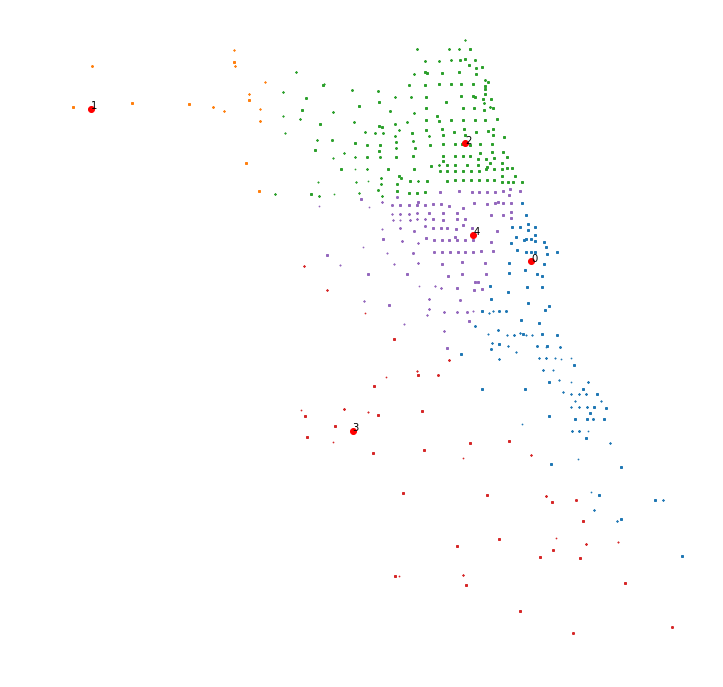

In [15]:
fig, ax = plt.subplots(1,1, figsize = FIG_SIZE)
for l in cl_df['labels']:
    plt.plot(loc_df.loc[loc_df['labels'] == l, 'longitude'], 
             loc_df.loc[loc_df['labels'] == l, 'latitude'], 
             '.',
             markersize = 1.5, 
             axes = ax, 
             figure = fig
        )
    plt.plot(cl_df.loc[cl_df['labels'] == l, 'longitude'], 
             cl_df.loc[cl_df['labels'] == l, 'latitude'], 
             'ro', 
             axes = ax, 
             figure = fig
        )
    ax.annotate(s=str(l),
                xy=(cl_df.loc[cl_df['labels'] == l, 'longitude'], 
                    cl_df.loc[cl_df['labels'] == l, 'latitude'])
        )
           
ax.set_axis_off()
plt.show();

In [16]:
# посмотрим где наши кластеры расположились на карте
chikago_map = folium.Map(location=[LAT_CONST, LON_CONST], 
                zoom_start=10,
                tiles='OpenStreetMap'
            )
# выставляем маркеры на карту Чикаго
for lon, lat in zip(cl_df['longitude'], cl_df['latitude']):
    folium.Marker(location=[lat, lon]).add_to(chikago_map)
chikago_map

<p style="text-indent:20px;">Можно заметить, что две самых удаленных от скопления мест посадок и высодок центроид кластеров находяться ровно около аэропортов(1,3), одна принадлежит северным жилым зонам Чикаго(2), а две центроиды можно отнести на деловой и культурный части (4,0) Чикаго.</p>
<p style="text-indent:20px;">Может показаться странным, что на южные жилые зоны Чикаго нет ярко выраженной центроиды, но если больше узнать об этом городе, то станет понятно, что это не так уж и странно. Южные кварталы Чикаго - это мексиканские и ирландские районы, в которых уровень жизни ниже северной части Чикаго.</p>

## <center>Визуализация трафика между центрами

<p style="text-indent:20px;">Для прогноза трафика между кластерами по часам необходимо: выделить час посадки и выставить метки принадлежности определенному кластеру для мест посадки и высадки.</p>

In [17]:
df['pickup_hour'] = df['trip_start_timestamp'].apply(lambda x: parser.parse(x).hour)
df['pickup_cluster'] = loc_df.loc[:len(df)-1,'labels'].values
df['dropoff_cluster'] = loc_df.loc[len(df):, 'labels'].values

<p style="text-indent:20px;">Начнем делать красоту (т.е. анимацию трафика между кластерами). Тот кто хочет получше разобраться с анимацией в matplotlib можно почитать документацию с <a href='https://matplotlib.org/api/animation_api.html'>официального сайта</a>.</p>


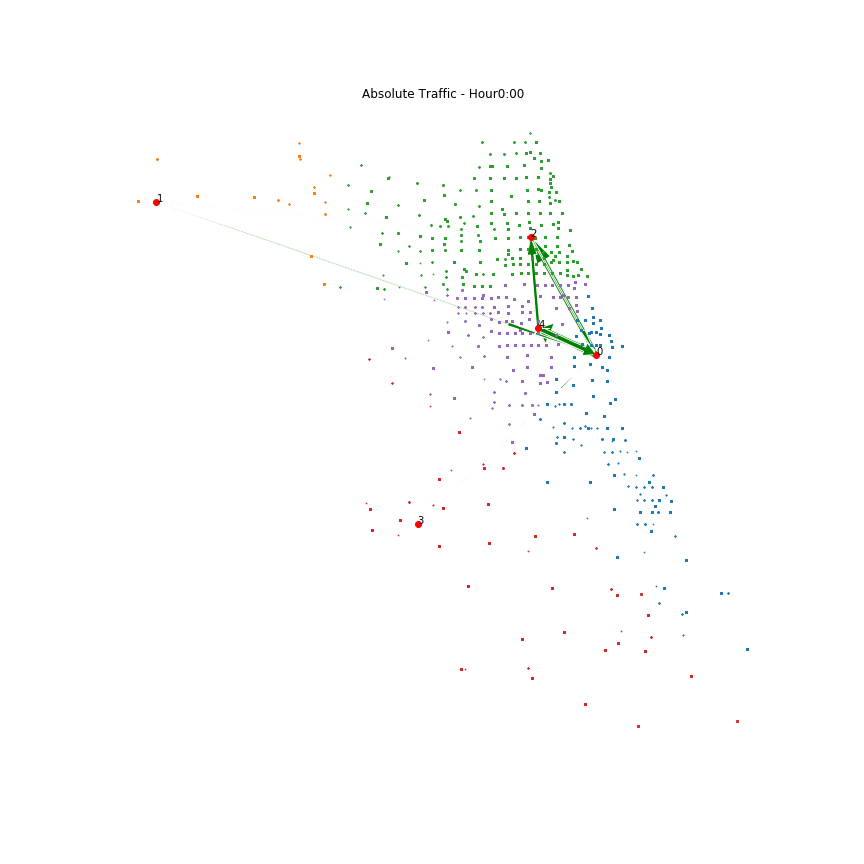

In [18]:
def trafic_animation(lon_ani_lim=None, lat_ani_lim=None, strong=6):
    # передовая пределы возможно ограничить зону 
    # изображения анимации
    # так же немаловажен параметр strong
    # который является маштабирующим коэффициентом
    # и влияет на ширину стрелок
    if (lon_ani_lim==None)|(lat_ani_lim==None):
        lim_cl_df = cl_df
    elif (len(lon_ani_lim)!=2)|(len(lat_ani_lim)!=2):
        lim_cl_df = cl_df
    else:
        lim_cl_df = cl_df[
            ((cl_df['longitude']>lon_ani_lim[0])&(cl_df['longitude']<lon_ani_lim[1]))&
            ((cl_df['latitude']>lat_ani_lim[0])&(cl_df['latitude']<lat_ani_lim[1]))
        ]
    fig, ax = plt.subplots(1,1, figsize = FIG_SIZE)
    
    
    # функция, которая будет передоваться в animation.FuncAnimation
    def animate(hour):
        # чистим все что было отрисовано ранее 
        ax.clear()
        # отрисовываем все заново
        ax.set_title('Absolute Traffic - Hour' + str(int(hour)) + ':00')
        plt.figure(figsize = FIG_SIZE)
        # статическая часть, она будет неизменна
        # но так как мы чистим все перед этим
        # то нам необходимо будет все отрисовать заново
        for l in lim_cl_df['labels']:
            ax.plot(loc_df.loc[loc_df['labels'] == l, 'longitude'], 
                     loc_df.loc[loc_df['labels'] == l, 'latitude'], 
                     '.',
                     markersize = 1.5
                )
            ax.plot(cl_df.loc[cl_df['labels'] == l, 'longitude'], 
                     cl_df.loc[cl_df['labels'] == l, 'latitude'], 
                     'ro'
                )
            ax.annotate(s=str(l),
                        xy=(cl_df.loc[cl_df['labels'] == l, 'longitude'], 
                            cl_df.loc[cl_df['labels'] == l, 'latitude'])
                )
        # динамическая часть(стрелочки)
        # они будут изменяться со временем
        for first_label in lim_cl_df['labels']:
            for second_label in lim_cl_df['labels']:
                # расчитываем количество поездов в данный час
                # из первого кластера во второй и из второго в первый
                num_of_rides = len(df[(df['pickup_cluster'] == first_label)&
                                     (df['dropoff_cluster'] == second_label)&
                                     (df['pickup_hour'] == hour)])
                # стрелка проводиться как и вектор по двум точкам
                # первую задаем начальными координатами
                # в качестве второй передаем разность от уже заданной
                # до второй точки по обеим осям
                dist_x = cl_df.longitude[cl_df['labels'] == first_label].values[0] - \
                        cl_df.longitude[cl_df['labels'] == second_label].values[0]
                    
                dist_y = cl_df.latitude[cl_df['labels'] == first_label].values[0] - \
                        cl_df.latitude[cl_df['labels'] == second_label].values[0]
                # нормировка количества поездок производится по всем поездкам
                pct = np.true_divide(num_of_rides, len(df))
                # непосредственное создание объекта Arrow
                # и его отрисовка
                arr = plt.Arrow(cl_df.longitude[cl_df['labels'] == first_label].values, 
                            cl_df.latitude[cl_df['labels'] == first_label].values,
                           -dist_x,
                           -dist_y,
                           edgecolor='white',
                           width=strong*pct
                        )
                ax.add_patch(arr)
                arr.set_facecolor('g')
                ax.set_axis_off()
    
    ani = animation.FuncAnimation(fig,
                                 animate,
                                 sorted(df['pickup_hour'].unique()),
                                 interval=1000
                    )
    # производим закрытие отрисованных графиков
    plt.close()
    # дириктори сохранения гифки
    gif_path = GIF_PATH
    # сохранение гифки
    ani.save(gif_path,
             writer='imagemagick',
             fps=1
        )
    # открываем сохраненную гифку и производим ее дешифрование
    # для дальнейшего URL и подстановки их в HTML
    video = io.open(gif_path,
                    'r+b'
                ).read()
    encoded = base64.b64encode(video)
    return encoded 

encoded = trafic_animation()
# производим отрисовку анимации
HTML(data='''<img src="data:image/gif;base64,{0}"type="gif"/>'''.format(
    encoded.decode('ascii')))


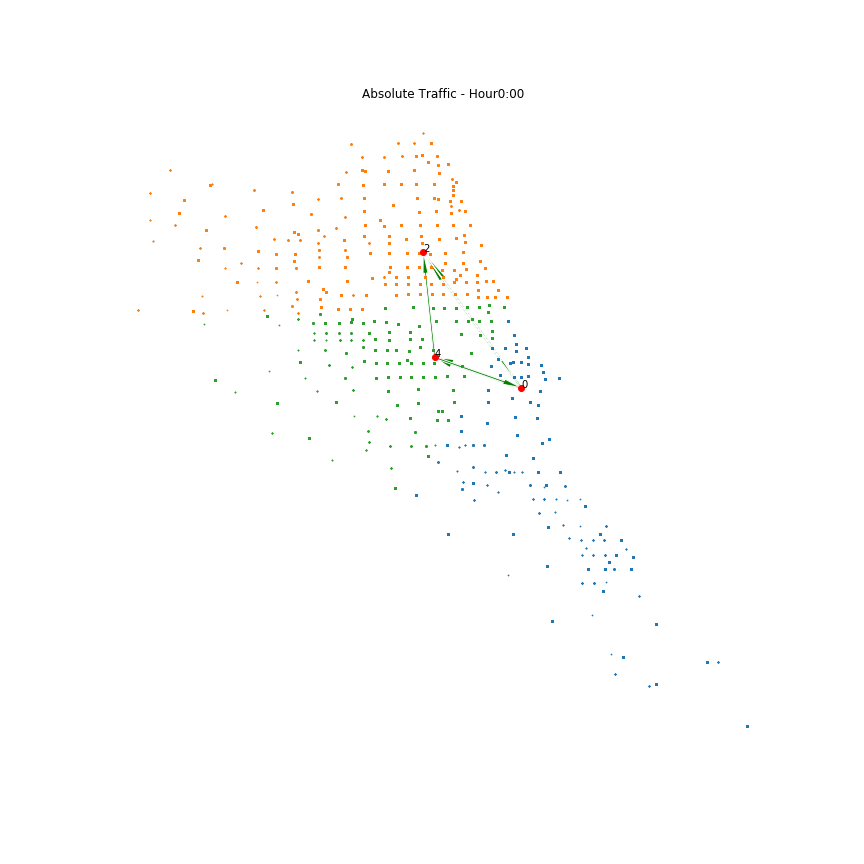

In [19]:
# присмотримся к центру города
encoded = trafic_animation(lon_ani_lim=LON_ANI_CENTER, 
                           lat_ani_lim=LAT_ANI_CENTER, 
                           strong=2
                )
HTML(data='''<img src="data:image/gif;base64,{0}"type="gif"/>'''.format(
    encoded.decode('ascii')))

<p style="text-indent:20px;">Прелесть такого рода визуализации в том, что ее может проинтерпритировать даже ребенок.</p>

## <center> Заключение

<p style="text-indent:20px;">Tensorflow довольно мощное API, которое хорошо подходит не только для обучения нейронных сетей. Хотя стоит отметит скудность документации(по сравнению с sklearn) по некоторым частям библиотеки. Одна из таких частей и была рассмотренна в данном тьюториале. Я так же надеюсь вам понравилась визуализации и вы влюбились в нее так же как и я когда впервые ее увидел. Если такого рода тьюториал вам понравится, то я подумаю о переносе его в виде статьи на хабрахабр и создании цикла такого рода статей.</p>

<p style="text-indent:20px;">Спасибо за внимание!</p>